<a href="https://colab.research.google.com/github/PARAS759/PetCura/blob/main/Dog_Breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gc
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import tensorflow as tf
from tqdm.autonotebook import tqdm
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.layers import Lambda, Input , GlobalAveragePooling2D , BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

<ipython-input-3-df3a8562e445>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
print("GPU", "available (YESS!!!)" if tf.config.list_physical_devices("GPU") else ("not available"))
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
labels = pd.read_csv('/content/drive/MyDrive/Data/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


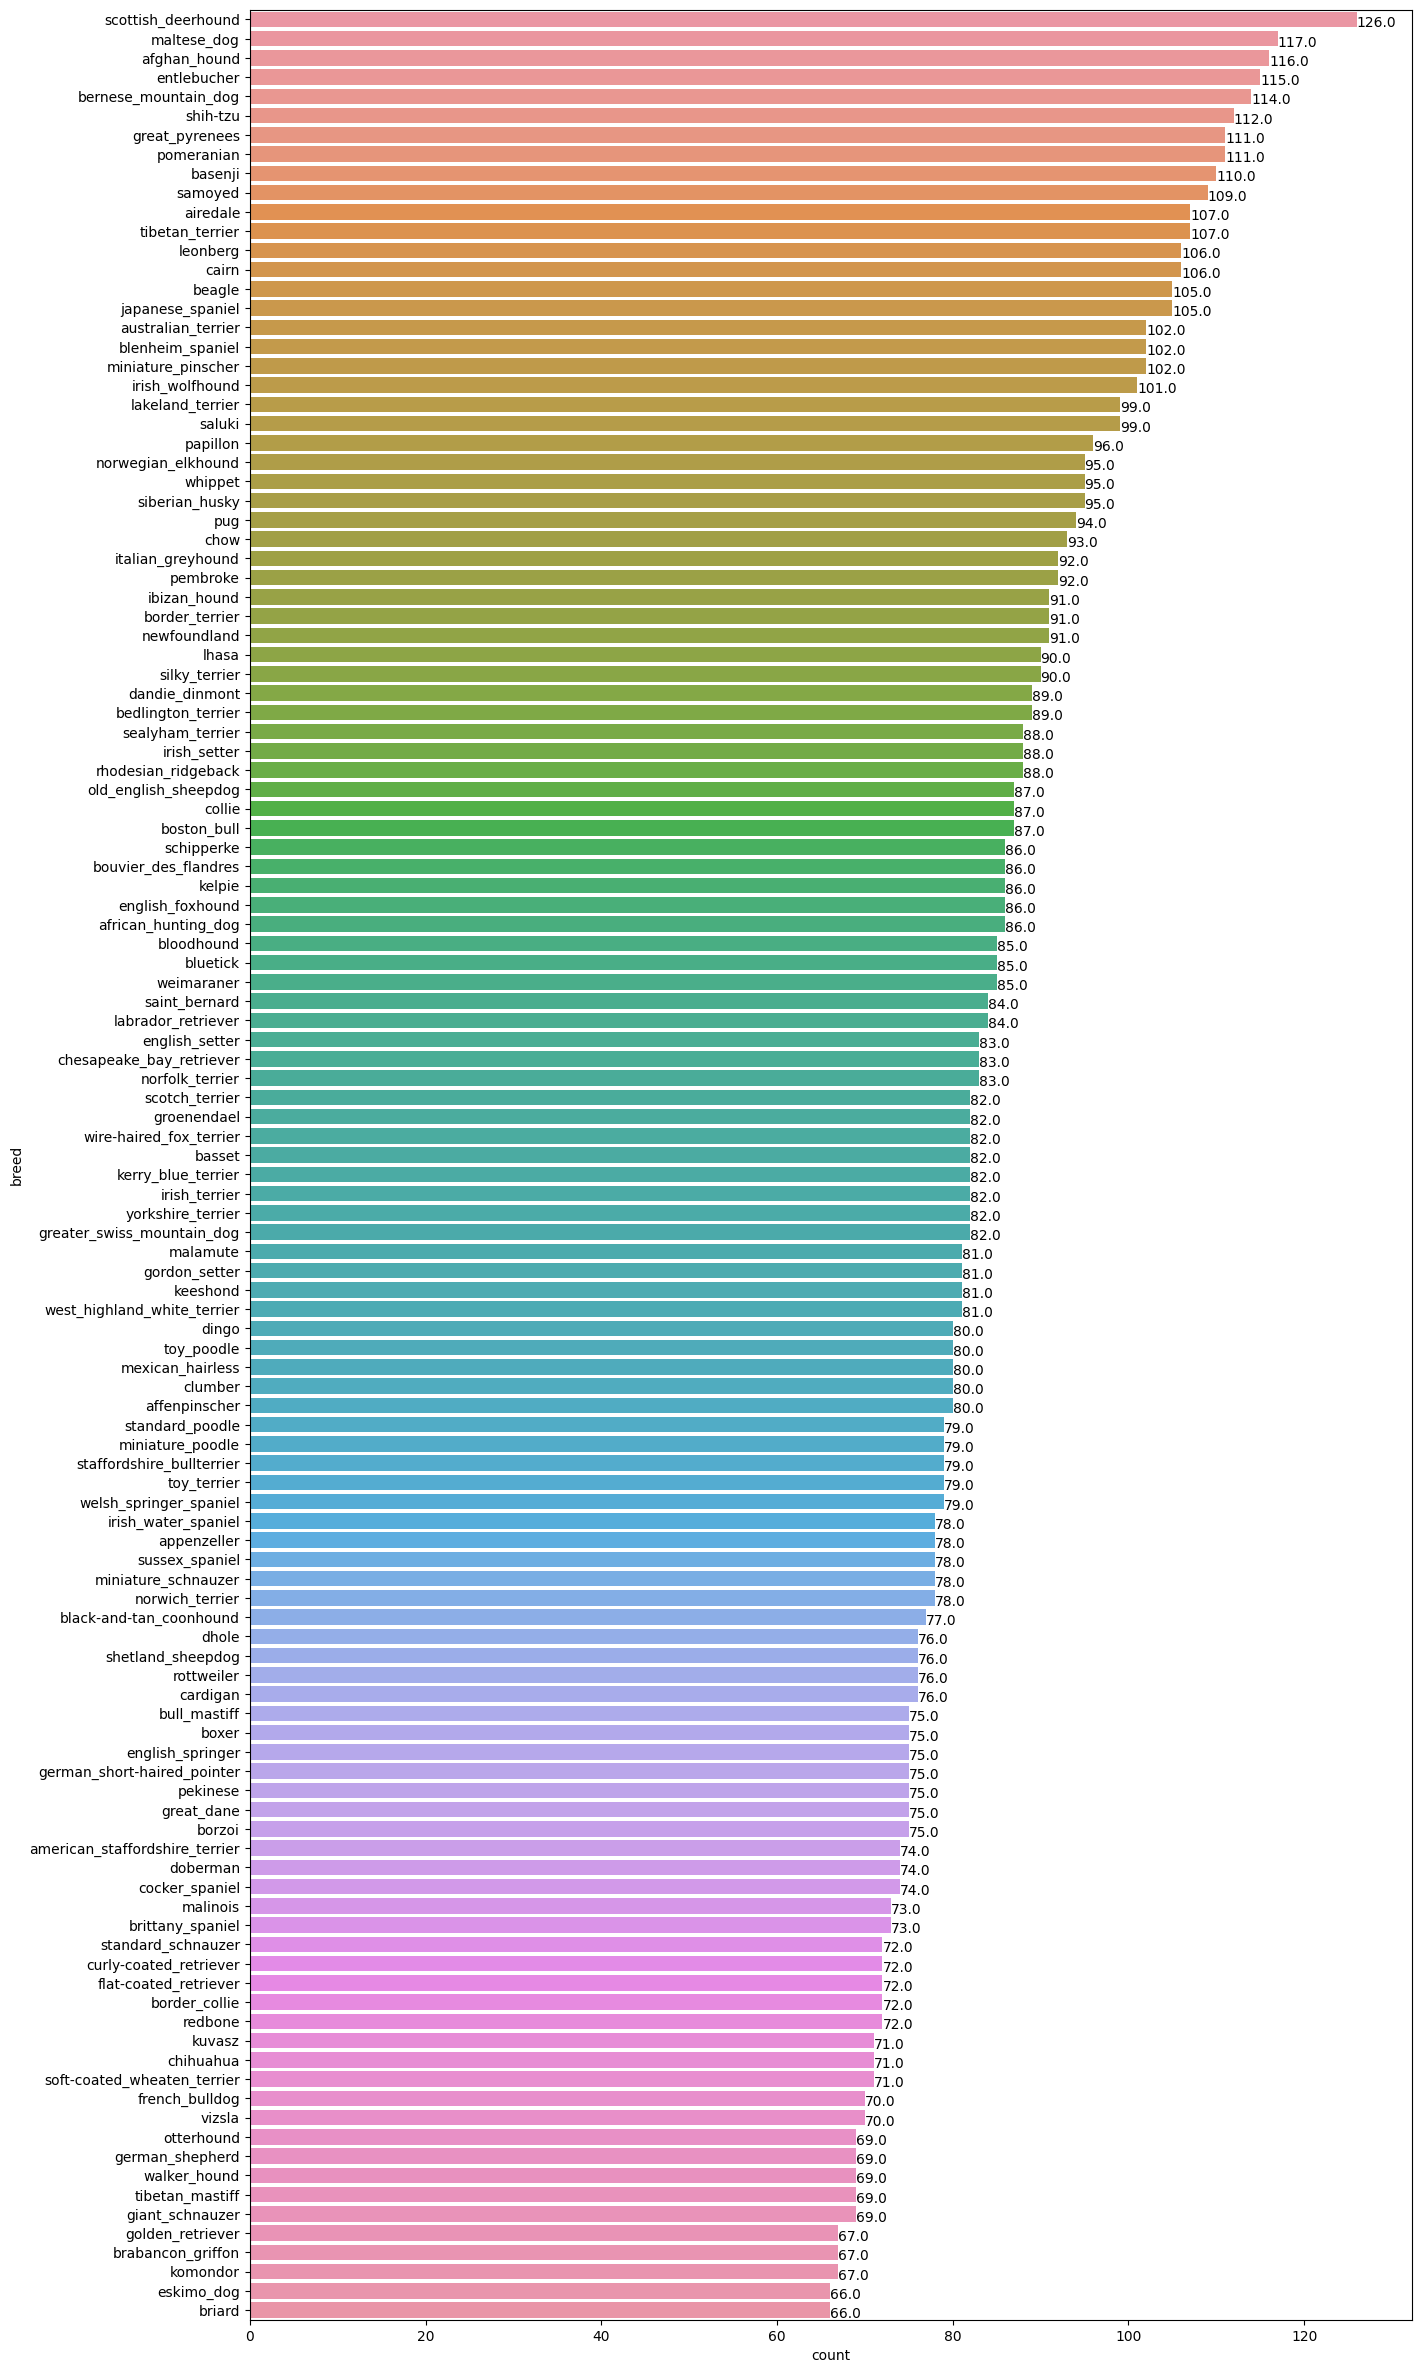

In [7]:
# function to show bar length
import seaborn as sns
def barw(ax):
  for p in ax.patches:
    val = p.get_width()
    x = p.get_x()+ p.get_width()
    y = p.get_y() + p.get_height()
    ax.annotate(round(val,2),(x,y))

# finding top dog brand
plt.figure(figsize = (15,30))
ax0 = sns.countplot(y = labels['breed'],order = labels['breed'].value_counts().index)
barw(ax0)
plt.show()

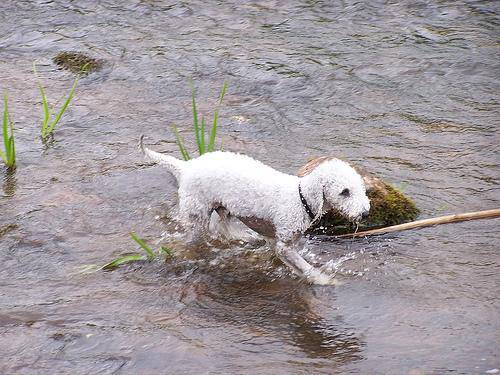

In [8]:
from IPython.display import display, Image
Image('/content/drive/MyDrive/Data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg')

In [9]:
classes  = sorted(list(set(labels['breed'])))
n_classes = len(classes)
# print('Total unique breed {}'.format(n_classes))

# Mappint each label string to an intefer label
class_to_num = dict(zip(classes , range(n_classes)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [10]:
input_shape = (250,250,3)

def images_to_array(directory , label_dataframe , target_size = input_shape):

  image_labels = label_dataframe['breed']
  images = np.zeros([len(label_dataframe) , target_size[0] , target_size[1] , target_size[2]],dtype = np.uint8)
  y = np.zeros([len(label_dataframe) , 1] , dtype = np.uint8)

  for ix,image_name in enumerate(tqdm(label_dataframe['id'].values)):
    img_dir = os.path.join(directory, image_name + '.jpg')
    img = load_img(img_dir,target_size = target_size)
    images[ix] = img
    del img
    dog_breed = image_labels[ix]
    y[ix] = class_to_num[dog_breed]
  y = to_categorical(y)
  return images,y


In [11]:
import time 
t = time.time()

X,y = images_to_array('/content/drive/MyDrive/Data/dog-breed-identification/train',labels[:])
print('runtime in seconds : {}'.format(time.time()-t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds : 7487.909337759018


In [12]:
# print(len(X))

In [13]:
# n = 25
# # setup the figure
# plt.figure(figsize = (20,20))

# for i in range(n):
#   ax = plt.subplot(5,5,i+1)
#   plt.title(classes[np.where(y[i] == 1)[0][0]])
#   plt.imshow(X[i])

In [14]:
lrr = ReduceLROnPlateau(monitor = 'val_acc',factor = .01 , patience = 3 , min_lr = 1e-5 , verbose = 1)
# prepare callbacks
EarlyStop = EarlyStopping(monitor = 'val_loss', patience = 10 , restore_best_weights = True)


In [15]:
# Hyperparameters
batch_size = 64
epochs = 30
learn_rate = .001
sgd = SGD(learning_rate = learn_rate , momentum = .9 , nesterov = False)
adam = Adam(learning_rate = learn_rate , beta_1 = 0.9 , beta_2 = 0.999 , epsilon = None , amsgrad = False)


#Feature Extraction by help of pretrained models



In [16]:
# function to extrract features from the dataset by a given pretrained mode
img_size = (250,250,3)

def get_features(mode_name , model_preprocessor , input_size , data):
  input_layer = Input(input_size)
  preprocessor = Lambda(model_preprocessor)(input_layer)
  base_model = mode_name(weights = 'imagenet' , include_top = False , input_shape = input_size)(preprocessor)
  avg  = GlobalAveragePooling2D()(base_model)
  feature_extractor = Model(inputs = input_layer , outputs = avg)

  # Extract feature
  feature_maps = feature_extractor.predict(data,verbose = 1)
  print('Feature maps shape : ',feature_maps.shape)
  return feature_maps

In [17]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3 , inception_preprocessor , img_size , X )

320/320 [==============================] - 34s 71ms/step
Feature maps shape :  (10222, 2048)


In [18]:
# Extract using Xception
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor =  preprocess_input
xception_features = get_features(Xception , xception_preprocessor , img_size , X)


320/320 [==============================] - 53s 156ms/step
Feature maps shape :  (10222, 2048)


In [19]:
# Extract features using InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2 , inc_resnet_preprocessor , img_size , X)

320/320 [==============================] - 66s 194ms/step
Feature maps shape :  (10222, 1536)


In [20]:
# Extract features using NASNetLarge
from keras.applications.nasnet import NASNetLarge , preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge , nasnet_preprocessor,img_size , X)

320/320 [==============================] - 150s 443ms/step
Feature maps shape :  (10222, 4032)


In [21]:
del X 
gc.collect()


133886

#Combination of features

In [22]:
# creating final featuremap by combining all extracted features
final_features  = np.concatenate([inception_features,xception_features,nasnet_features,inc_resnet_features,],axis = -1)
print('Final feature maps shape' , final_features.shape)

Final feature maps shape (10222, 9664)


#Preparing Input Layer with 0.7 Dropout

In [23]:
model = Sequential()
model.add(Dropout(0,7,input_shape = (final_features.shape[1],)))
model.add(Dense(n_classes,activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# Training the model...............
history = model.fit(final_features,y,batch_size = batch_size , epochs = epochs , validation_split = 0.2 , callbacks = [lrr,EarlyStop])


Epoch 1/30
125/128 [============================>.] - ETA: 0s - loss: 0.8641 - accuracy: 0.8064

128/128 [==============================] - 3s 7ms/step - loss: 0.8609 - accuracy: 0.8073 - val_loss: 0.6001 - val_accuracy: 0.8572 - lr: 0.0010
Epoch 2/30
114/128 [=========================>....] - ETA: 0s - loss: 0.2792 - accuracy: 0.9180

128/128 [==============================] - 1s 5ms/step - loss: 0.2775 - accuracy: 0.9187 - val_loss: 0.5858 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/30
126/128 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9454

128/128 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9453 - val_loss: 0.5965 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 4/30
114/128 [=========================>....] - ETA: 0s - loss: 0.1072 - accuracy: 0.9642

128/128 [==============================] - 1s 5ms/step - loss: 0.1147 - accuracy: 0.9633 - val_loss: 0.6522 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 5/30
118/128 [==========================>...] - ETA: 0s - loss: 0.0703 - accuracy: 0.9774

128/128 [==============================] - 1s 6ms/step - loss: 0.0692 - accuracy: 0.9776 - val_loss: 0.5539 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 6/30
124/128 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9878

128/128 [==============================] - 1s 7ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.5423 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 7/30
127/128 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9897

128/128 [==============================] - 1s 6ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.5306 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9960

128/128 [==============================] - 1s 6ms/step - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.5428 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 9/30
121/128 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9960

128/128 [==============================] - 1s 7ms/step - loss: 0.0157 - accuracy: 0.9962 - val_loss: 0.5357 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 10/30
127/128 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9974

128/128 [==============================] - 1s 7ms/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 0.5158 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 11/30
119/128 [==========================>...] - ETA: 0s - loss: 0.0097 - accuracy: 0.9983

128/128 [==============================] - 1s 5ms/step - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.5441 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 12/30
117/128 [==========================>...] - ETA: 0s - loss: 0.0152 - accuracy: 0.9965

128/128 [==============================] - 1s 5ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.5367 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 13/30
120/128 [===========================>..] - ETA: 0s - loss: 0.0122 - accuracy: 0.9973

128/128 [==============================] - 1s 5ms/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.5677 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 14/30
125/128 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9941

128/128 [==============================] - 1s 5ms/step - loss: 0.0252 - accuracy: 0.9941 - val_loss: 0.6391 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 15/30
120/128 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9868

128/128 [==============================] - 1s 4ms/step - loss: 0.0641 - accuracy: 0.9858 - val_loss: 0.8177 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 16/30
126/128 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9655

128/128 [==============================] - 1s 5ms/step - loss: 0.1405 - accuracy: 0.9656 - val_loss: 1.1233 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9607

128/128 [==============================] - 1s 5ms/step - loss: 0.1607 - accuracy: 0.9607 - val_loss: 1.1826 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 18/30
117/128 [==========================>...] - ETA: 0s - loss: 0.1016 - accuracy: 0.9750

128/128 [==============================] - 1s 5ms/step - loss: 0.1000 - accuracy: 0.9752 - val_loss: 1.1444 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 19/30
127/128 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9814

128/128 [==============================] - 1s 5ms/step - loss: 0.0679 - accuracy: 0.9815 - val_loss: 1.0460 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 20/30
127/128 [============================>.] - ETA: 0s - loss: 0.0308 - accuracy: 0.9927

128/128 [==============================] - 1s 5ms/step - loss: 0.0308 - accuracy: 0.9927 - val_loss: 1.0189 - val_accuracy: 0.8733 - lr: 0.0010


In [24]:
# deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

1551

In [25]:
# Fuction to read images from test directory 
from __future__ import annotations
def images_to_array_test(test_path, img_size = (250,250,3)):
  test_filenames = [test_path+fname for fname in os.listdir(test_path)]

  data_size = len(test_filenames)
  images = np.zeros([data_size , img_size[0] , img_size[1],3],dtype = np.uint8)

  for ix,img_dir in enumerate(tqdm(test_filenames)):
    img = load_img(img_dir, target_size = img_size)
    images[ix] = img
    del img
  print('Output Datasize : ',images.shape)
  return images
test_data = images_to_array_test('/content/drive/MyDrive/Data/dog-breed-identification/test/',)

  0%|          | 0/10396 [00:00<?, ?it/s]

Output Datasize :  (10396, 250, 250, 3)


In [26]:
# Extract features from test dataset
def extract_features(data):
  inception_features = get_features(InceptionV3 , inception_preprocessor , img_size , data)
  xception_features = get_features(Xception,xception_preprocessor , img_size , data)
  nasnet_features = get_features(NASNetLarge,nasnet_preprocessor , img_size , data)
  inc_resnet_features = get_features(InceptionResNetV2 , inc_resnet_preprocessor , img_size , data)

  final_features = np.concatenate([inception_features , xception_features , nasnet_features , inc_resnet_features],axis = -1)

  print('Final feature maps shape' , final_features.shape)

  return final_features

test_features = extract_features(test_data)


325/325 [==============================] - 28s 81ms/step
Feature maps shape :  (10396, 2048)
325/325 [==============================] - 58s 176ms/step
Feature maps shape :  (10396, 2048)
325/325 [==============================] - 151s 447ms/step
Feature maps shape :  (10396, 4032)
325/325 [==============================] - 67s 197ms/step
Feature maps shape :  (10396, 1536)
Final feature maps shape (10396, 9664)


In [27]:
# Predict test labels given test data features
pred  = model.predict(test_features)


325/325 [==============================] - 1s 2ms/step


In [28]:
# First prediction
print(pred[1])
print(f"Max value (probability of prediction): {np.max(pred[1])}")
print(f"Sum: {np.sum(pred[1])}")
print(f"Max index: {np.argmax(pred[1])}")
print(f"Predicted Label: {classes[np.argmax(pred[1])]}")

[6.14030105e-10 6.01643665e-11 1.01429143e-09 2.69621636e-09
 1.64282157e-10 3.46178260e-11 1.72684124e-11 1.46539314e-09
 3.24164415e-12 2.28391698e-11 3.29763150e-09 1.20225206e-12
 7.35599244e-13 1.05126741e-10 9.10243408e-12 1.55203877e-12
 1.62881698e-12 1.97162165e-11 6.79960984e-14 3.10971515e-08
 3.18431150e-11 3.94159809e-11 1.01679099e-11 2.64271296e-11
 1.12808773e-11 5.31252542e-11 2.38842609e-11 2.99424339e-11
 3.38625031e-11 2.45862822e-07 2.12731447e-11 1.10812063e-11
 4.00772243e-13 2.39090220e-10 6.78694878e-11 3.32553504e-14
 6.38171807e-12 2.22538862e-10 7.37391792e-09 7.29488258e-12
 9.49023846e-11 3.03731484e-11 1.10650955e-14 1.60676177e-11
 2.15486760e-11 1.59756572e-12 1.35307026e-11 4.25451558e-12
 2.60971095e-13 8.33981356e-11 5.45400487e-12 1.38342301e-07
 1.17637594e-10 7.67512703e-12 5.55097721e-12 2.64896188e-10
 1.10816295e-11 5.54472912e-10 2.58872540e-13 5.41319489e-11
 1.04841808e-06 1.15207843e-11 6.68142069e-11 6.32506963e-11
 3.04778793e-12 2.989210

In [29]:
import pickle

In [30]:
pickle.dump(model, open('model.pkl', 'wb'))

In [31]:
# import tensorflow as tf
# keras_clf = KerasClassifier(model = model, optimizer=tf.keras.optimizers.Adam(), epochs=100, verbose=0)

In [32]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [33]:
Image = ('/content/download.jpeg')

In [35]:
img_g = load_img('/content/download.jpeg',target_size = img_size)
img_g = np.expand_dims(img_g,axis=0)

In [36]:
img_g.shape

(1, 250, 250, 3)

In [41]:
test_features = extract_features(img_g)
predg = pickled_model.predict(test_features)
print(f"Predict_label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction : {round(np.max(predg[0]))*100} %")

1/1 [==============================] - 1s 1s/step
Feature maps shape :  (1, 2048)
1/1 [==============================] - 1s 706ms/step
Feature maps shape :  (1, 2048)
1/1 [==============================] - 5s 5s/step
Feature maps shape :  (1, 4032)
1/1 [==============================] - 3s 3s/step
Feature maps shape :  (1, 1536)
Final feature maps shape (1, 9664)
1/1 [==============================] - 0s 41ms/step
Predict_label: pug
Probability of prediction : 100 %
